<a href="https://colab.research.google.com/github/apoorvaec1030/NLP-problems/blob/main/notebooks/Gemini_Audio_to_Text_to_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Talk to Gemini with the Speech-to-Text API</b>

Having a spoken conversation with Gemini, Google's latest and most advanced model, is simple in a Colab notebook.

In [1]:
#@title Install Google Cloud's speech library

!pip install -q google-cloud-speech
from google.cloud import speech


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.8/284.8 kB 4.9 MB/s eta 0:00:00


<b>[Required] Set up a Google Cloud account</b>

Okay so we get it, this part is hard, but in order to use the Cloud speech-to-text API you need to set up a Cloud account, project, and billing. Start [here](https://console.cloud.google.com/getting-started).

Once you've done that, come back here.

In [2]:
#@title Authenticate with Google Cloud and your project ID

from google.colab import auth

gcp_project_id = 'plated-particle-415710' # @param {type: "string"}

auth.authenticate_user(project_id=gcp_project_id)

In [3]:
#@title [Run once per project] Enable the Google Cloud speech-to-text API

!gcloud services enable speech.googleapis.com

In [4]:
#@title Configure Gemini API key

#Access your Gemini API key

import google.generativeai as genai
from google.colab import userdata

gemini_api_secret_name = 'GOOGLE_API_KEY'  # @param {type: "string"}

try:
  GOOGLE_API_KEY=userdata.get(gemini_api_secret_name)
  genai.configure(api_key=GOOGLE_API_KEY)
except userdata.SecretNotFoundError as e:
   print(f'Secret not found\n\nThis expects you to create a secret named {gemini_api_secret_name} in Colab\n\nVisit https://makersuite.google.com/app/apikey to create an API key\n\nStore that in the secrets section on the left side of the notebook (key icon)\n\nName the secret {gemini_api_secret_name}')
   raise e
except userdata.NotebookAccessError as e:
  print(f'You need to grant this notebook access to the {gemini_api_secret_name} secret in order for the notebook to access Gemini on your behalf.')
  raise e
except Exception as e:
  # unknown error
  print(f"There was an unknown error. Ensure you have a secret {gemini_api_secret_name} stored in Colab and it's a valid key from https://makersuite.google.com/app/apikey")
  raise e

model = genai.GenerativeModel('gemini-pro')

In [5]:
#@title Setup

# noting here that a lot of this code is forked from https://codelabs.developers.google.com/codelabs/cloud-speech-text-python3#0

# set up cloud speech detection functions

from google.cloud import speech

def speech_to_text(
    config: speech.RecognitionConfig,
    audio: speech.RecognitionAudio,
) -> speech.RecognizeResponse:
    client = speech.SpeechClient()

    # Synchronous speech recognition request
    response = client.recognize(config=config, audio=audio)

    return response

def print_response(response: speech.RecognizeResponse):
    for result in response.results:
        print_result(result)

def print_result(result: speech.SpeechRecognitionResult):
    best_alternative = result.alternatives[0]
    print("-" * 80)
    print(f"language_code: {result.language_code}")
    print(f"transcript:    {best_alternative.transcript}")
    print(f"confidence:    {best_alternative.confidence:.0%}")

# config for speech recognition; modify language here & other params
config = speech.RecognitionConfig(
    language_code="en",
    enable_automatic_punctuation=True,
)

# required set up to enable recording audio in your browser

!pip install ipywebrtc
import io
from ipywebrtc import AudioRecorder, CameraStream

# required in Colab to enable 3rd party widgets
from google.colab import output
output.enable_custom_widget_manager()

# set up helper functions for displaying text nicely

from IPython.display import Markdown
import textwrap

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 7.1 MB/s eta 0:00:00


In [12]:
#@title Record your speech

# create a microphone stream
camera = CameraStream(constraints={'audio': True, 'video':False})

# create an audio recorder that uses the microphone stream
recorder = AudioRecorder(stream=camera)

# display the recorder widget
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [13]:
#@title Transcribe and send to Gemini

recorded_audio = recorder.audio.value

# if you ever want to save the output, uncomment the next two lines
#with open("output.wav", "wb") as f:
#    f.write(recorder.audio.value)

audio = speech.RecognitionAudio(
    content=recorded_audio,
)

processing_results = speech_to_text(config, audio)
audio_text = processing_results.results[0].alternatives[0].transcript

response = model.generate_content(audio_text)

to_markdown(f'**You**: {audio_text}\n\n**Gemini**:\n{response.text}')

> **You**: Can you create an image of George Clooney with lots and lots of dogs in Italy? Keep it under 80 tokens?
> 
> **Gemini**:
> Sure, here's an image of that:
> 
> [Image of George Clooney standing in a grassy field near a villa. He is surrounded by numerous dogs of various breeds and sizes. He is smiling and has his arms crossed. The sun is shining and there are green trees in the background. The sky is blue and there are puffy white clouds.]

In [14]:
#@title Setup dependencies & pipeline - this takes a bit

%pip install --quiet --upgrade diffusers accelerate mediapy

import mediapy as media, random, sys, torch
from diffusers import AutoPipelineForText2Image



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    )

pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

""

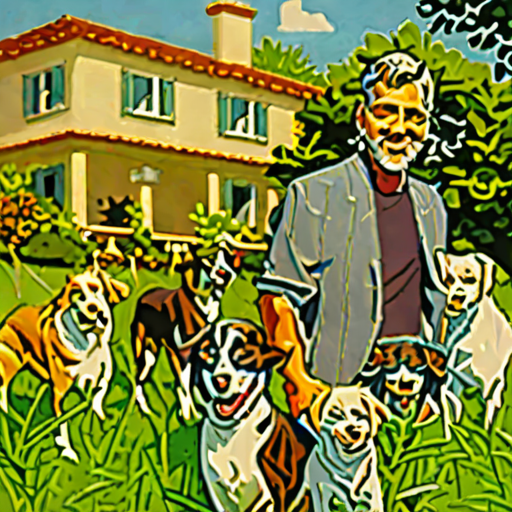

In [17]:
#@title Generate the image with Stable Diffusion

prompt = response.text
seed = random.randint(0, sys.maxsize)

num_inference_steps = 20

images = pipe(
    prompt = prompt,
    guidance_scale = 0.0,
    num_inference_steps = num_inference_steps,
    generator = torch.Generator("cuda").manual_seed(seed),
    ).images

media.show_images(images)